In [11]:
import cv2
import numpy as np

class GazeAnnotator:
    def __init__(self, class_list_file, annotation_priority = None, gaze_tolerance = 0.5, distance_from_screen = 150, width_of_screen = 120):
        #In degrees gaze_tolerance
        #In cm distance_from_screen
        #In cm width_of_screen
        self.gaze_tolerance = gaze_tolerance
        self.distance_from_screen = distance_from_screen
        self.width_of_screen = width_of_screen

        self.load_class_list(class_list_file)

        if annotation_priority is None:
            # higher means more priority
            self.annotation_priority= {'Sky': 1,
                                        'Others': 1,
                                        'InsideCar': 2,
                                        'Road': 3,
                                        'Sidewalk': 4,
                                        'Speedometer': 4,
                                        'RoadSign': 7,
                                        'TrafficSignal': 8,
                                        'Car': 9,
                                        'People': 10,}
        else:
            self.annotation_priority = annotation_priority

        
        self.annotation_weights_byname = {k: (np.exp(v/3)-1) for k, v in self.annotation_priority.items()}

        self.annotation_weights_byobjID = {}
        for k, v in self.annotation_weights_byname.items():
            self.annotation_weights_byobjID[self.obj2objID[k]] = v
        
    def load_class_list(self, class_list_file):
        self.objID2obj = {}
        self.objID2rgb = {} # This is actually bgr and not rgb

        with open(class_list_file,'r') as f:
            classes = f.readlines()
            for i, line in enumerate(classes):
                name,r,g,b = line.split(',')
                if i:
                    name = name.strip()
                    r = int(r)
                    g = int(g)
                    b = int(b)
                    self.objID2obj[i] = name
                    self.objID2rgb[i] = [b,g,r]

        self.obj2objID = {str(v): k for k, v in self.objID2obj.items()}
        self.rgb2objID = {str(v): k for k, v in self.objID2rgb.items()}


        

    def get_pixels_in_circle(self,center,radius,max_dim):
        low_x = min(max(0,int(center[0]-radius)),max_dim[0])
        low_y = min(max(0,int(center[1]-radius)),max_dim[1])
        
        high_x = min(max(0,int(center[0]+radius)),max_dim[0])
        high_y = min(max(0,int(center[1]+radius)),max_dim[1])
        
        radius_sq = radius*radius
        pixels = [(x,y) for x in range(low_x,high_x) for y in range(low_y,high_y) if (((x-center[0])**2 + (y-center[1])**2)<radius_sq)]    
        return pixels

    def get_objName_pixel(self,rgb_val):
        return self.objID2obj[rgb2objID[str(rgb_val)]]


    def get_objName_area(self,rgb_vals_list, probability = False):
        objID_list = [self.rgb2objID[str(rgb_val)] for rgb_val in rgb_vals_list]
        
        objID_weightedlist = [0]*256
        for objID in objID_list:
            objID_weightedlist[objID] += self.annotation_weights_byobjID[objID]

        max_objID = objID_weightedlist.index(max(objID_weightedlist))
        if not probability:
            return self.objID2obj[max_objID]
        else:
            objID_weightedlist_probs = np.array(objID_weightedlist)/sum(objID_weightedlist)
            prob_dict = {}
            for objID in np.where(objID_weightedlist_probs>0)[0]:
                prob_dict[self.objID2obj[objID]] = objID_weightedlist_probs[objID]
            return (self.objID2obj[max_objID], prob_dict)

    def get_gaze_annotation(self,img_rgb,eyetracking_agg_data):
        # Get eyetracking location         
        # img_rgb = cv2.imread('frame_4329_pred.png')
        # eyetracking_agg_data = [[50,30],[50,30],[50,30]]    

        height, width, _ = img_rgb.shape
         
        gaze_location = np.median(eyetracking_agg_data,axis = 0)
        gaze_location[0] = int(gaze_location[0]*width/100)
        gaze_location[1] = int(gaze_location[1]*height/100)
        gaze_radius_px = (self.gaze_tolerance*np.pi/180)*(self.distance_from_screen/self.width_of_screen)*width
        pixels =  self.get_pixels_in_circle(gaze_location,gaze_radius_px,(width,height))
        rgb_vals_list = [[img_rgb[y,x,0],img_rgb[y,x,1],img_rgb[y,x,2]]  for (x,y) in pixels]
        
        return self.get_objName_area(rgb_vals_list, probability = True)

In [12]:
gaze_annotator = GazeAnnotator('class_dict.csv')
img_rgb = cv2.imread('frame_4329_pred.png')
eyetracking_agg_data = [[50,30],[50,30],[50,30]]
gaze_annotator.get_gaze_annotation(img_rgb,eyetracking_agg_data)

('Sky', {'Sky': 0.9540034071550253, 'Others': 0.04599659284497473})

In [40]:
class_list_file = 'class_dict.csv'
objID2obj = {}
objID2rgb = {} # This is actually bgr and not rgb

with open(class_list_file,'r') as f:
    classes = f.readlines()
    for i, line in enumerate(classes):
        name,r,g,b = line.split(',')
        if i:
            name = name.strip()
            r = int(r)
            g = int(g)
            b = int(b)
            objID2obj[i] = name
            objID2rgb[i] = [b,g,r]

obj2objID = {str(v): k for k, v in objID2obj.items()}
rgb2objID = {str(v): k for k, v in objID2rgb.items()}


# higher means more priority
annotation_priority= {'Sky': 1,
                      'Others': 1,
                      'InsideCar': 2,
                      'Road': 3,
                      'Sidewalk': 4,
                      'Speedometer': 4,
                      'RoadSign': 7,
                      'TrafficSignal': 8,
                      'Car': 9,
                      'People': 10}
            


In [41]:
obj2objID

{'People': 1,
 'Car': 2,
 'Sky': 3,
 'Road': 4,
 'Sidewalk': 5,
 'TrafficSignal': 6,
 'RoadSign': 7,
 'InsideCar': 8,
 'Speedometer': 9,
 'Others': 10}

In [42]:

def get_pixels_in_circle(center,radius,max_dim):
    low_x = min(max(0,int(center[0]-radius)),max_dim[0])
    low_y = min(max(0,int(center[1]-radius)),max_dim[1])
    
    high_x = min(max(0,int(center[0]+radius)),max_dim[0])
    high_y = min(max(0,int(center[1]+radius)),max_dim[1])
    
    radius_sq = radius*radius
    pixels = [(x,y) for x in range(low_x,high_x) for y in range(low_y,high_y) if (((x-center[0])**2 + (y-center[1])**2)<radius_sq)]    
    return pixels

def get_objName_pixel(rgb_val):
    return objID2obj[rgb2objID[str(rgb_val)]]

annotation_weights_byname = {k: (np.exp(v/3)-1) for k, v in annotation_priority.items()}

annotation_weights_byobjID = {}
for k, v in annotation_weights_byname.items():
    annotation_weights_byobjID[obj2objID[k]] = v

def get_objName_area(rgb_vals_list, probability = False):
    objID_list = [rgb2objID[str(rgb_val)] for rgb_val in rgb_vals_list]
    
    objID_weightedlist = [0]*256
    for objID in objID_list:
        objID_weightedlist[objID] += annotation_weights_byobjID[objID]

    if not probability:
        max_objID = objID_weightedlist.index(max(objID_weightedlist))
        return objID2obj[max_objID]
    else:
        objID_weightedlist_probs = np.array(objID_weightedlist)/sum(objID_weightedlist)
        prob_dict = {}
        for objID in np.where(objID_weightedlist_probs>0)[0]:
            prob_dict[objID2obj[objID]] = objID_weightedlist_probs[objID]
        return prob_dict
    
    


In [43]:
# Get eyetracking location        
eyetracking_agg_data = [[62,50]]    
# eyetracking_agg_data = [[50,30],[50,30],[50,30]]    


height, width, _ = img_rgb.shape
objName = 'Failed'
gaze_location = [-1,-1]     
if len(eyetracking_agg_data):  
    gaze_location = np.median(eyetracking_agg_data,axis = 0)
    gaze_location[0] = int(gaze_location[0]*width/100)
    gaze_location[1] = int(gaze_location[1]*height/100)
    gaze_radius_px = (gaze_tolerance*np.pi/180)*(distance_from_screen/width_of_screen)*width
    pixels =  get_pixels_in_circle(gaze_location,gaze_radius_px,(width,height))
    rgb_vals_list = [[img_rgb[y,x,0],img_rgb[y,x,1],img_rgb[y,x,2]]  for (x,y) in pixels]
    objName = get_objName_area(rgb_vals_list)
    prob_dict = get_objName_area(rgb_vals_list, probability = True)

    

[0, 1594.8658687770428, 0, 0, 0, 92.19104052454487, 0, 0, 0, 0, 195.8281504176131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1594.8658687770428, 0, 0, 0, 92.19104052454487, 0, 0, 0, 0, 195.8281504176131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

('People',
 {'People': 0.8470330467303665,
  'Sidewalk': 0.04896264912649184,
  'Others': 0.1040043041431416})

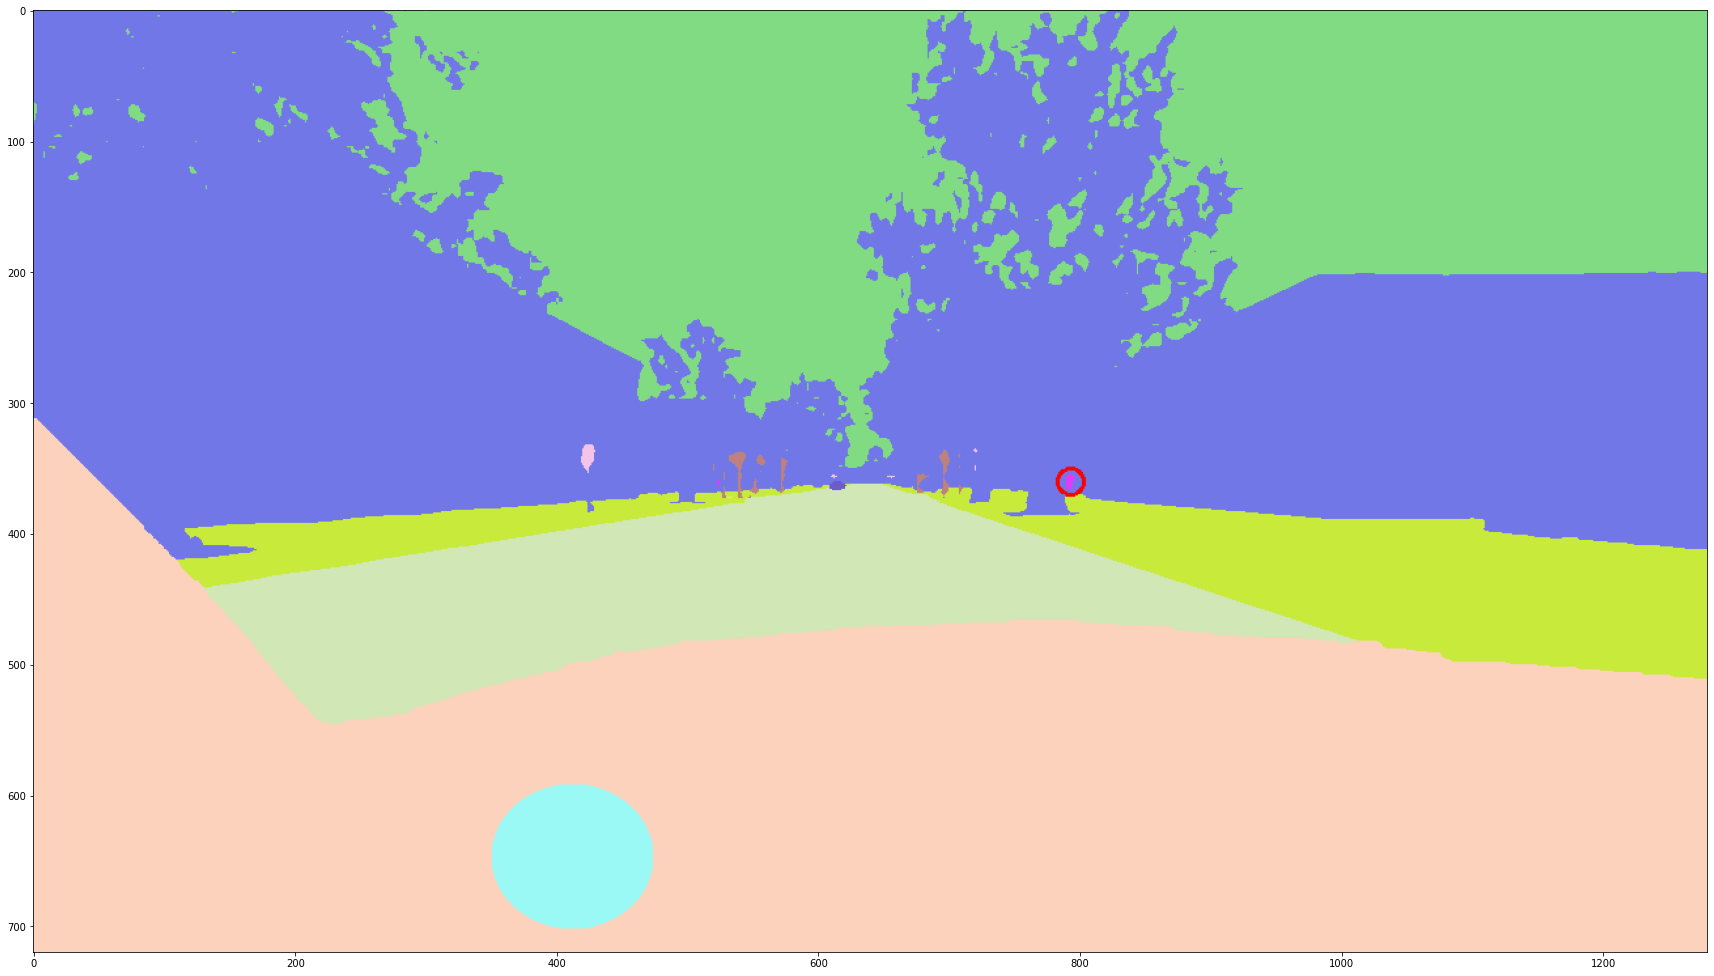

In [44]:
plt.figure(figsize=(30,30))
cv2.circle(img_rgb, (int(gaze_location[0]),int(gaze_location[1])), 10, (0,0,255), 2)  
plt.imshow(cv2.cvtColor(img_rgb,cv2.COLOR_BGR2RGB))
objName, prob_dict

In [45]:
gaze_location

array([793., 360.])

In [46]:
annotation_weights_byobjID

{3: 0.3956124250860895,
 10: 0.3956124250860895,
 8: 0.9477340410546757,
 4: 1.718281828459045,
 5: 2.7936678946831774,
 9: 2.7936678946831774,
 7: 9.312258501325767,
 6: 13.391916095149892,
 2: 19.085536923187668,
 1: 27.03162489452614}